# Cervical Fracture Detection – Simple CNN (Kaggle Notebook)

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

# Kaggle HDF5 path
h5_path = "/kaggle/input/rsna-2022-hdf5-subset/fracture_dataset_subset.h5"

print("Using PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Using PyTorch version: 2.6.0+cu124
Device: cuda


In [2]:
with h5py.File(h5_path, "r") as f:
    print("HDF5 keys:")
    for k in f.keys():
        print(" ", k, "->", f[k].shape)

    # Load full arrays into memory (subset is manageable)
    images = f["images"][:]           # (N, 256, 256)
    labels = f["labels"][:]           # (N,)
    split  = f["split"][:]            # (N,)
    # Optional: study / bbox info if you want it later
    study_uid = f["StudyInstanceUID"][:]
    slice_num = f["SliceNumber"][:]

print("images:", images.shape, images.dtype)
print("labels:", labels.shape, labels.dtype)
print("split:", split.shape, split.dtype)

HDF5 keys:
  SliceNumber -> (28812,)
  StudyInstanceUID -> (28812,)
  bboxes -> (28812, 10, 4)
  images -> (28812, 256, 256)
  labels -> (28812,)
  split -> (28812,)
images: (28812, 256, 256) float32
labels: (28812,) int8
split: (28812,) int8


## EDA

Label 0: 21609 slices
Label 1: 7203 slices


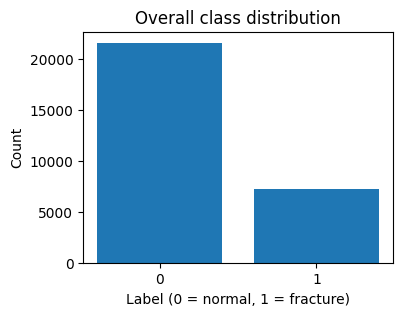

In [4]:
unique_labels, counts = np.unique(labels, return_counts=True)
for u, c in zip(unique_labels, counts):
    print(f"Label {u}: {c} slices")

plt.figure(figsize=(4,3))
plt.bar(unique_labels.astype(str), counts)
plt.title("Overall class distribution")
plt.xlabel("Label (0 = normal, 1 = fracture)")
plt.ylabel("Count")
plt.show()

In [5]:
split_codes, split_counts = np.unique(split, return_counts=True)
print("Split codes and counts:")
for s, c in zip(split_codes, split_counts):
    print(f"Split {s}: {c} slices")

def frac_per_split(code, name):
    mask = (split == code)
    u, c = np.unique(labels[mask], return_counts=True)
    print(f"\n{name} split (code {code}) class distribution:")
    for uu, cc in zip(u, c):
        print(f"  Label {uu}: {cc} slices ( {cc / mask.sum():.2%} )")

frac_per_split(0, "Train")
frac_per_split(1, "Val")
frac_per_split(2, "Test")

Split codes and counts:
Split 0: 20744 slices
Split 1: 4180 slices
Split 2: 3888 slices

Train split (code 0) class distribution:
  Label 0: 15558 slices ( 75.00% )
  Label 1: 5186 slices ( 25.00% )

Val split (code 1) class distribution:
  Label 0: 3135 slices ( 75.00% )
  Label 1: 1045 slices ( 25.00% )

Test split (code 2) class distribution:
  Label 0: 2916 slices ( 75.00% )
  Label 1: 972 slices ( 25.00% )


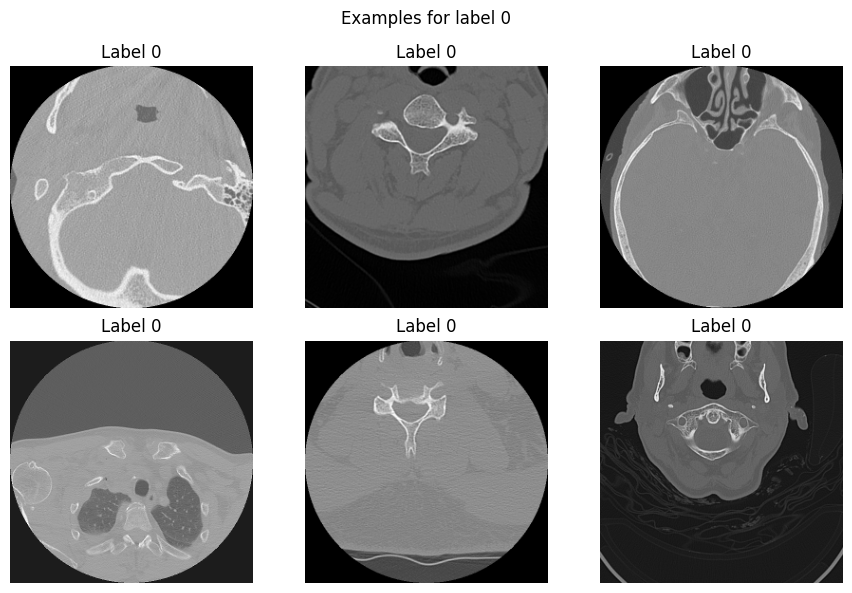

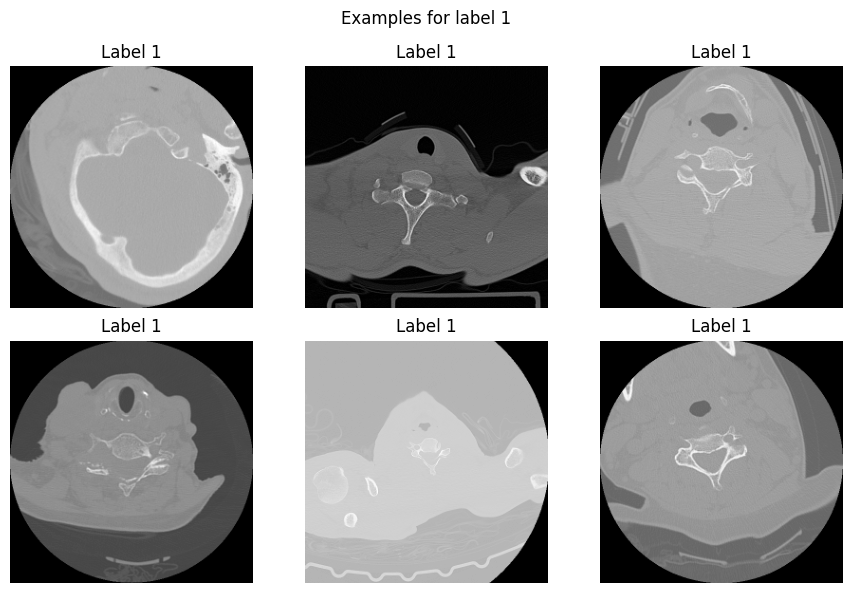

In [6]:
def show_examples(label_value, n=6):
    idx = np.where(labels == label_value)[0]
    idx = np.random.choice(idx, size=min(n, len(idx)), replace=False)
    cols = 3
    rows = int(np.ceil(len(idx) / cols))
    plt.figure(figsize=(cols*3, rows*3))
    for i, j in enumerate(idx):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[j], cmap="gray")
        plt.axis("off")
        plt.title(f"Label {labels[j]}")
    plt.suptitle(f"Examples for label {label_value}")
    plt.tight_layout()
    plt.show()

show_examples(0)
show_examples(1)

## Simple CNN Model

In [7]:
# Get dataloader script from GitHub
!wget https://raw.githubusercontent.com/apmalinsky/AAI-590-Capstone/refs/heads/main/scripts/dataloader.py

--2025-12-08 01:17:05--  https://raw.githubusercontent.com/apmalinsky/AAI-590-Capstone/refs/heads/main/scripts/dataloader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4645 (4.5K) [text/plain]
Saving to: ‘dataloader.py’

dataloader.py       100%[===================>]   4.54K  --.-KB/s    in 0s      

2025-12-08 01:17:05 (46.0 MB/s) - ‘dataloader.py’ saved [4645/4645]



In [8]:
# Import dataloader script
from dataloader import get_dataloaders

In [10]:
# Get data loaders for classification
batch_size = 32

train_loader, val_loader, test_loader = get_dataloaders(
    hdf5_path=h5_path,
    batch_size=batch_size,
    task='classification',
    num_workers=2
)

# Check one batch
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")

Loading dataset for task: 'classification'...
Loading splits...
DataLoaders created.
Batch shape: torch.Size([32, 1, 256, 256]), Labels shape: torch.Size([32])


In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 256 -> 128

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 128 -> 64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 64 -> 32
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout

In [12]:
def run_one_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    all_preds = []
    all_targets = []
    running_loss = 0.0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            if is_train:
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        all_preds.append(preds.detach().cpu().numpy())
        all_targets.append(labels.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_targets, all_preds)
    epoch_f1 = f1_score(all_targets, all_preds, average="binary")

    return epoch_loss, epoch_acc, epoch_f1, all_targets, all_preds

In [13]:
num_epochs = 10
best_val_f1 = 0.0
best_state = None

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc, train_f1, _, _ = run_one_epoch(
        model, train_loader, criterion, optimizer=optimizer
    )

    val_loss, val_acc, val_f1, _, _ = run_one_epoch(
        model, val_loader, criterion, optimizer=None
    )

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = model.state_dict()

    print(
        f"Epoch {epoch:02d} "
        f"Train loss {train_loss:.4f} acc {train_acc:.3f} f1 {train_f1:.3f}  "
        f"Val loss {val_loss:.4f} acc {val_acc:.3f} f1 {val_f1:.3f}"
    )

if best_state is not None:
    model.load_state_dict(best_state)
    print("Loaded best model with val F1:", best_val_f1)

Epoch 01 Train loss 0.6890 acc 0.749 f1 0.190  Val loss 0.4716 acc 0.751 f1 0.085
Epoch 02 Train loss 0.4328 acc 0.767 f1 0.158  Val loss 0.5267 acc 0.748 f1 0.071
Epoch 03 Train loss 0.3953 acc 0.770 f1 0.167  Val loss 0.5913 acc 0.750 f1 0.074
Epoch 04 Train loss 0.3620 acc 0.790 f1 0.517  Val loss 0.6528 acc 0.739 f1 0.362
Epoch 05 Train loss 0.3194 acc 0.835 f1 0.706  Val loss 0.9525 acc 0.740 f1 0.204
Epoch 06 Train loss 0.2837 acc 0.865 f1 0.755  Val loss 1.0678 acc 0.751 f1 0.226
Epoch 07 Train loss 0.2567 acc 0.880 f1 0.782  Val loss 1.6730 acc 0.755 f1 0.196
Epoch 08 Train loss 0.2209 acc 0.902 f1 0.820  Val loss 1.4210 acc 0.752 f1 0.214
Epoch 09 Train loss 0.1974 acc 0.916 f1 0.845  Val loss 1.9507 acc 0.754 f1 0.172
Epoch 10 Train loss 0.1725 acc 0.931 f1 0.872  Val loss 2.2255 acc 0.753 f1 0.133
Loaded best model with val F1: 0.3618266978922717


In [14]:
test_loss, test_acc, test_f1, y_true_test, y_pred_test = run_one_epoch(
    model, test_loader, criterion, optimizer=None
)

print("\n=== Test set performance ===")
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test F1 (binary): {test_f1:.3f}")

print("\nClassification report (test):")
print(classification_report(y_true_test, y_pred_test, digits=3))


=== Test set performance ===
Test loss: 2.8271
Test accuracy: 0.757
Test F1 (binary): 0.140

Classification report (test):
              precision    recall  f1-score   support

           0      0.762     0.983     0.859      2916
           1      0.611     0.079     0.140       972

    accuracy                          0.757      3888
   macro avg      0.687     0.531     0.499      3888
weighted avg      0.724     0.757     0.679      3888



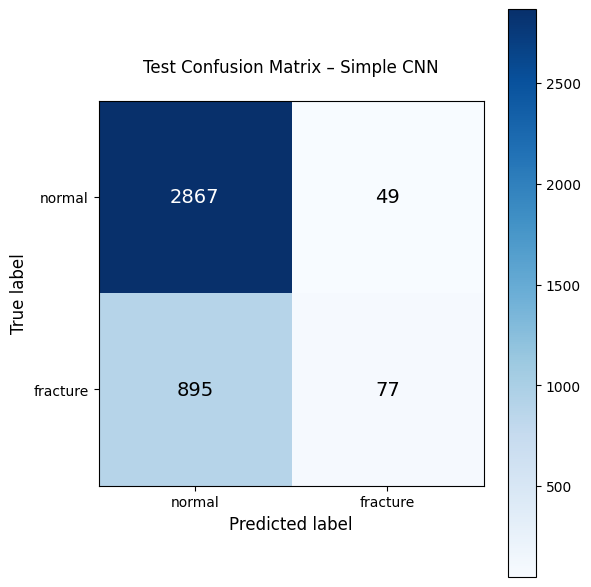

In [22]:
# Confusion matrix for test set
cm_test = confusion_matrix(y_true_test, y_pred_test)

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm_test, cmap="Blues")

# Use white for dark cells
threshold = cm_test.max() / 2.0 
text_color_high = "white"
text_color_low = "black"

ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(["normal", "fracture"], fontsize=10)
ax.set_yticklabels(["normal", "fracture"], fontsize=10)

for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        color = text_color_high if cm_test[i, j] > threshold else text_color_low
        ax.text(j, i, cm_test[i, j], ha="center", va="center", 
                fontsize=14,color=color)

plt.title("Test Confusion Matrix – Simple CNN", pad=20)
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()